# Q-Learning Algorithm Implementation

This notebook provides a step-by-step implementation of the Q-Learning algorithm, a fundamental reinforcement learning technique. We'll use a simple grid world environment to demonstrate how an agent learns to find optimal policies through exploration and exploitation.

## Concepts Covered:

1. **Q-Learning Basics**:
   - State-Action Value Function (Q-table)
   - Exploration vs. Exploitation (ε-greedy policy)
   - Reward Structure and Discounting

2. **Key Parameters**:
   - Learning rate (α): How much new information overrides old information
   - Discount factor (γ): Importance of future rewards
   - Exploration rate (ε): Probability of taking random actions
   
3. **Learning Process**:
   - Q-table initialization
   - Action selection using ε-greedy
   - Q-value updates using the Q-learning formula
   - Policy improvement over time

We'll implement this in a clear, step-by-step manner with visualizations to understand how the agent learns.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List
import random
from IPython.display import clear_output
import time

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

class GridWorld:
    """A simple 4x4 grid world environment for Q-Learning demonstration.
    
    The agent starts at (0,0) and needs to reach the goal at (3,3).
    There are walls and holes to avoid, making the task non-trivial.
    """
    
    def __init__(self, size: int = 4):
        self.size = size
        self.action_space = ["up", "right", "down", "left"]
        self.n_actions = len(self.action_space)
        self.reset()
        
        # Define walls and holes (state: reward)
        self.special_states = {
            (1, 1): -1.0,  # hole
            (2, 1): -1.0,  # hole
            (1, 2): float('-inf'),  # wall
            (2, 3): -1.0,  # hole
        }
        
        # Goal state
        self.goal_state = (3, 3)
        
    def reset(self) -> Tuple[int, int]:
        """Reset agent to start state."""
        self.agent_pos = (0, 0)
        return self.agent_pos
    
    def get_valid_actions(self) -> List[str]:
        """Return list of valid actions from current state."""
        valid = []
        x, y = self.agent_pos
        
        if x > 0 and (x-1, y) not in self.get_wall_positions():  # up
            valid.append("up")
        if x < self.size-1 and (x+1, y) not in self.get_wall_positions():  # down
            valid.append("down")
        if y > 0 and (x, y-1) not in self.get_wall_positions():  # left
            valid.append("left")
        if y < self.size-1 and (x, y+1) not in self.get_wall_positions():  # right
            valid.append("right")
            
        return valid
    
    def get_wall_positions(self) -> List[Tuple[int, int]]:
        """Return positions of walls."""
        return [(x, y) for (x, y), r in self.special_states.items() 
                if r == float('-inf')]
    
    def step(self, action: str) -> Tuple[Tuple[int, int], float, bool]:
        """Take action and return new state, reward, and done flag."""
        if action not in self.get_valid_actions():
            return self.agent_pos, -0.1, False  # Invalid action penalty
        
        # Move agent
        x, y = self.agent_pos
        if action == "up": x -= 1
        elif action == "down": x += 1
        elif action == "left": y -= 1
        elif action == "right": y += 1
        
        self.agent_pos = (x, y)
        
        # Check if done and get reward
        if self.agent_pos == self.goal_state:
            return self.agent_pos, 1.0, True
        elif self.agent_pos in self.special_states:
            reward = self.special_states[self.agent_pos]
            done = reward == float('-inf')  # done if hit wall
            return self.agent_pos, reward, done
        else:
            return self.agent_pos, -0.01, False  # Small penalty for each move
        
    def render(self, q_table=None) -> None:
        """Visualize the grid world and optionally show Q-values/policy."""
        # Create grid for visualization
        grid = np.zeros((self.size, self.size))
        
        # Mark special states
        for (x, y), reward in self.special_states.items():
            if reward == float('-inf'):
                grid[x, y] = -2  # wall
            else:
                grid[x, y] = -1  # hole
        
        # Mark goal
        grid[self.goal_state] = 2
        
        # Mark agent
        agent_x, agent_y = self.agent_pos
        grid[agent_x, agent_y] = 1
        
        # Create figure and plot grid
        plt.figure(figsize=(10, 10))
        
        # Plot grid
        sns.heatmap(grid, cmap='RdYlGn', center=0, annot=True, fmt='.1f',
                    cbar=False, square=True)
        
        # If Q-table provided, plot arrows for policy
        if q_table is not None:
            for i in range(self.size):
                for j in range(self.size):
                    if (i,j) == self.goal_state or (i,j) in self.special_states:
                        continue
                    
                    # Get best action
                    state_q_values = q_table[i,j]
                    best_action = self.action_space[np.argmax(state_q_values)]
                    
                    # Draw arrow
                    if best_action == "up": plt.arrow(j+0.5, i+0.7, 0, -0.4, head_width=0.1)
                    elif best_action == "down": plt.arrow(j+0.5, i+0.3, 0, 0.4, head_width=0.1)
                    elif best_action == "left": plt.arrow(j+0.7, i+0.5, -0.4, 0, head_width=0.1)
                    elif best_action == "right": plt.arrow(j+0.3, i+0.5, 0.4, 0, head_width=0.1)
        
        plt.title("Grid World\nAgent (1), Goal (2), Holes (-1), Walls (-2)")
        plt.show()

In [2]:
class QLearningAgent:
    """Q-Learning agent implementation with clear, educational focus."""
    
    def __init__(self, env: GridWorld, learning_rate: float = 0.1, 
                 discount_factor: float = 0.95, epsilon: float = 0.1):
        """Initialize Q-Learning agent.
        
        Args:
            env: GridWorld environment
            learning_rate: How much to update Q-values (α)
            discount_factor: Importance of future rewards (γ)
            epsilon: Probability of random action (ε)
        """
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        
        # Initialize Q-table with zeros
        # Shape: (grid_size, grid_size, number_of_actions)
        self.q_table = np.zeros((env.size, env.size, env.n_actions))
        
    def get_action(self, state: Tuple[int, int]) -> str:
        """Select action using ε-greedy policy.
        
        With probability ε, choose random action for exploration.
        Otherwise, choose best action from Q-table for exploitation.
        """
        if random.random() < self.epsilon:
            # Explore: random action
            return random.choice(self.env.get_valid_actions())
        else:
            # Exploit: best action from Q-table
            x, y = state
            return self.env.action_space[np.argmax(self.q_table[x, y])]
    
    def learn(self, n_episodes: int = 500) -> List[float]:
        """Train the agent using Q-Learning algorithm.
        
        Args:
            n_episodes: Number of training episodes
            
        Returns:
            List of rewards per episode for plotting learning curve
        """
        rewards_history = []
        
        for episode in range(n_episodes):
            state = self.env.reset()
            total_reward = 0
            done = False
            
            while not done:
                # 1. Select action using ε-greedy
                action = self.get_action(state)
                
                # 2. Take action and observe result
                action_idx = self.env.action_space.index(action)
                next_state, reward, done = self.env.step(action)
                
                # 3. Q-Learning update
                # Q(s,a) = Q(s,a) + α * [R + γ * max(Q(s',a')) - Q(s,a)]
                current_q = self.q_table[state[0], state[1], action_idx]
                next_max_q = np.max(self.q_table[next_state[0], next_state[1]])
                
                new_q = current_q + self.learning_rate * (
                    reward + self.discount_factor * next_max_q - current_q)
                
                self.q_table[state[0], state[1], action_idx] = new_q
                
                # 4. Update state and accumulate reward
                state = next_state
                total_reward += reward
            
            rewards_history.append(total_reward)
            
            # Decay exploration rate
            self.epsilon = max(0.01, self.epsilon * 0.995)
            
            # Optionally visualize training progress
            if (episode + 1) % 100 == 0:
                clear_output(wait=True)
                print(f"Episode: {episode + 1}")
                self.env.render(self.q_table)
                time.sleep(0.5)
        
        return rewards_history

Episode: 500


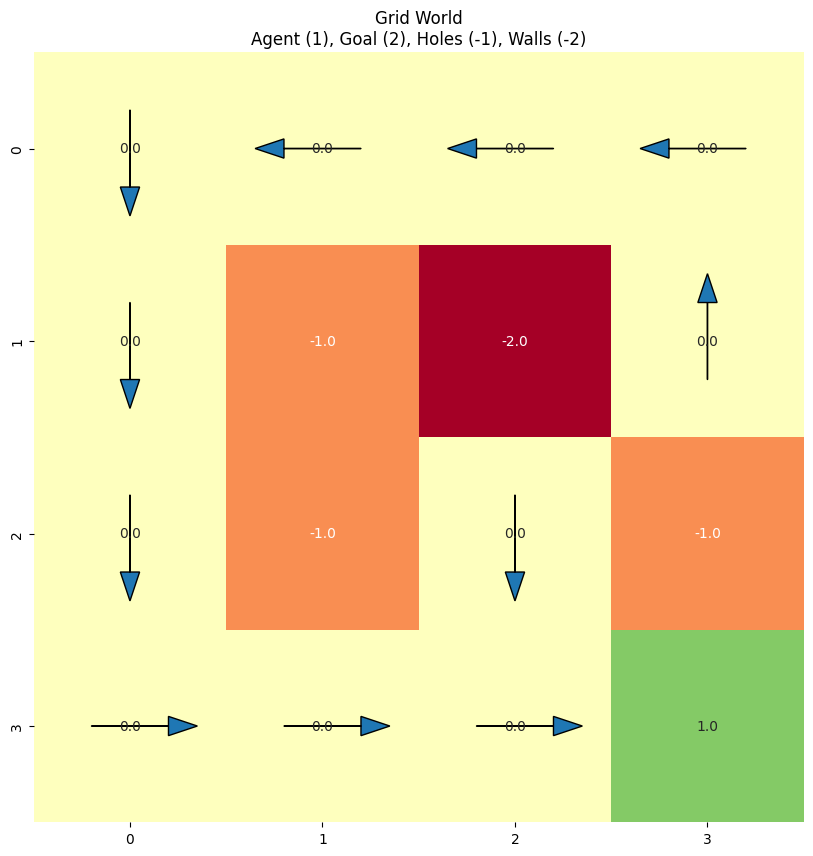

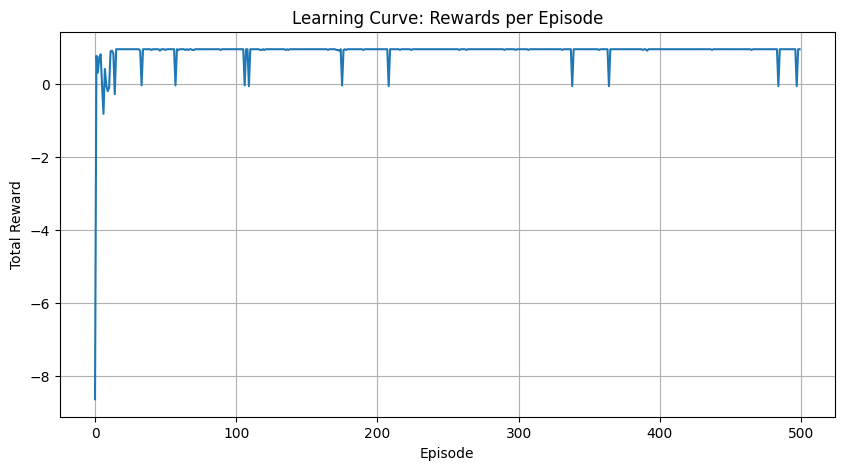


Final learned policy (arrows show optimal actions):


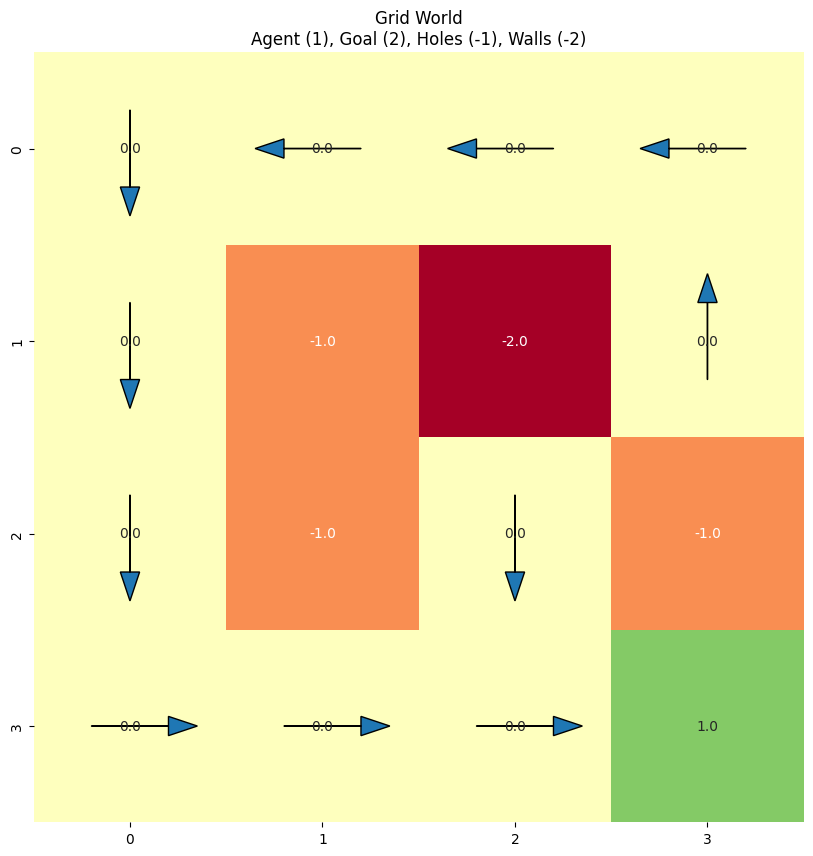


Example Q-values at start state (0,0):
up: -0.020
right: 0.049
down: 0.729
left: -0.020


In [3]:
# Create environment and agent
env = GridWorld()
agent = QLearningAgent(env, learning_rate=0.1, discount_factor=0.95, epsilon=0.1)

# Show initial environment
print("Initial Environment:")
env.render()

# Train agent
print("\nTraining agent...")
rewards_history = agent.learn(n_episodes=500)

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.plot(rewards_history)
plt.title('Learning Curve: Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

# Show final policy
print("\nFinal learned policy (arrows show optimal actions):")
env.render(agent.q_table)

# Print some interesting Q-values
print("\nExample Q-values at start state (0,0):")
for action, q_value in zip(env.action_space, agent.q_table[0,0]):
    print(f"{action}: {q_value:.3f}")

## Understanding the Results

### Learning Process
1. The agent starts with no knowledge (Q-table of zeros)
2. Through exploration (ε-greedy), it discovers the environment
3. Q-values are updated based on rewards and future estimates
4. The exploration rate (ε) decays over time, leading to more exploitation
5. Eventually, the agent learns the optimal path to the goal

### Interpreting the Visualization
- **Grid Values**: 
  - Agent position (1)
  - Goal state (2)
  - Holes (-1)
  - Walls (-2)
- **Arrows**: Show the optimal action in each state according to learned Q-values
- **Learning Curve**: Shows how total rewards improve over episodes

### Key Observations
1. **Initial Exploration**: Early episodes have lower rewards due to random actions
2. **Learning Progress**: Rewards generally increase as the agent learns
3. **Policy Convergence**: Arrows show the shortest safe path to the goal
4. **State Values**: Q-values are higher for states closer to the goal

### Practical Applications
- Path finding and navigation
- Resource allocation
- Game AI
- Robot control
- Any sequential decision-making problem

### Possible Extensions
1. Try different reward structures
2. Modify environment (size, obstacles)
3. Experiment with hyperparameters:
   - Learning rate (α)
   - Discount factor (γ)
   - Exploration rate (ε)
4. Add visual trajectories of learned paths
5. Implement other exploration strategies (e.g., UCB, softmax)